In [1]:
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("requests")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1663266944220_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 13.1 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 111.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.8/959.8 kB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.2 MB/s eta 0:00:00

In [152]:
import os
import numpy as np
import requests
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from io import BytesIO
from itertools import product
from PIL import Image
from typing import Tuple, List
from collections import namedtuple
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from time import time

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [182]:
Tile = namedtuple("Tile", ("zoom", "x", "y"))

TEMP_DIR = "data"
DATASET_URL_FORMAT = "s3://elevation-tiles-prod/terrarium"
ZOOM = 3
BOUNDS = (72.0, -168.0, -54.0, -25.0)
TILE_WIDTH = 256
TILE_HEIGHT = 256
CHANNELS_NUM = 3
RED_CHANNEL_MULTIPLIER = 256
GREEN_CHANNEL_MULTIPLIER = 1
BLUE_CHANNEL_MULTIPLIER = 1/256
INCREMENT_OFFSET = 32768
GRADIENT_GROUPS = {
    0: 2,
    1: 10,
    2: 100,
    3: 150,
    4: 500,
    5: 5000
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [183]:
def mercator(lat: float, lon: float, zoom: int) -> Tuple[int, int, int]:
    """Convert latitude, longitude to z/x/y tile coordinate at given zoom."""
    # convert to radians
    x1, y1 = lon * np.pi / 180, lat * np.pi / 180

    # project to mercator
    x2, y2 = x1, np.log(np.tan(0.25 * np.pi + 0.5 * y1))

    # transform to tile space
    tiles, diameter = 2 ** zoom, 2 * np.pi
    x3, y3 = int(tiles * (x2 + np.pi) / diameter), int(tiles * (np.pi - y2) / diameter)

    return zoom, x3, y3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [184]:
def get_tiles(zoom: int, lat1: float, lon1: float, lat2: float, lon2: float) -> List[Tile]:
    ''' Convert geographic bounds into a list of tile coordinates at given zoom.'''
    # convert to geographic bounding box
    minlat, minlon = min(lat1, lat2), min(lon1, lon2)
    maxlat, maxlon = max(lat1, lat2), max(lon1, lon2)

    # convert to tile-space bounding box
    _, xmin, ymin = mercator(maxlat, minlon, zoom)
    _, xmax, ymax = mercator(minlat, maxlon, zoom)

    # generate a list of tiles
    xs, ys = range(xmin, xmax+1), range(ymin, ymax+1)
    tiles = [Tile(zoom, x, y) for (y, x) in product(ys, xs)]

    return tiles

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [185]:
def generate_links(tiles: List[Tile]) -> List[str]:
  return [f"{DATASET_URL_FORMAT}/{tile.zoom}/{tile.x}/{tile.y}.png" for tile in tiles]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [186]:
def calculate_elevation(rgb: Tuple[int, int, int]) -> float:
  '''Calculates elevation on certain pixel'''
  elevation = rgb[2]*RED_CHANNEL_MULTIPLIER + rgb[1]*GREEN_CHANNEL_MULTIPLIER + rgb[0]*BLUE_CHANNEL_MULTIPLIER - INCREMENT_OFFSET
  return elevation if elevation > 0 else 0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [187]:
def get_elevation(tile: np.ndarray) -> np.ndarray:
  '''Calculates elevation for whole map tile'''
  return np.array([list(map(calculate_elevation, row)) for row in tile])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [188]:
def match_to_group(elevation: float) -> int:
  '''Matches pixel elevation to one of 6 groups'''
  for group_id, elevation_treshold in GRADIENT_GROUPS.items():
    if elevation < elevation_treshold:
      return int(group_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [189]:
def group_elevation(tile: np.ndarray) -> np.ndarray:
  '''Groups tile elevations'''
  return np.array([list(map(match_to_group, np.abs(row))) for row in tile[0]])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [190]:
def get_x_from_image_path(image_path: str) -> int:
  cleaned = image_path.replace(f"{DATASET_URL_FORMAT}/", "").replace(".png", "")
  return int(cleaned.split("/")[1])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [191]:
def get_y_from_image_path(image_path: str) -> int:
  cleaned = image_path.replace(f"{DATASET_URL_FORMAT}/", "").replace(".png", "")
  return int(cleaned.split("/")[2])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [192]:
tiles = get_tiles(ZOOM, *BOUNDS)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [193]:
data_urls = generate_links(tiles)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [194]:
df = spark.read.format("image").load(data_urls)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [195]:
start = time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [196]:
df = df.select("image.origin", "image.data")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [197]:
col_x = F.udf(get_x_from_image_path, IntegerType())
col_y = F.udf(get_y_from_image_path, IntegerType())
df = df.withColumn("x", col_x(df.origin))
df = df.withColumn("y", col_y(df.origin))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [198]:
df = df.orderBy(F.col("x").asc(), F.col("y").asc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [199]:
df_images = df.select("data")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [200]:
# images_count = df_images.count()
# tile_rows = df_images.collect()
# tiles_arr = [np.reshape(tile_rows[i][0], (TILE_HEIGHT, TILE_WIDTH, CHANNELS_NUM)) for i in range(images_count)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [201]:
tiles_rdd = df_images.rdd.map(lambda img: np.reshape(img, (TILE_HEIGHT, TILE_WIDTH, CHANNELS_NUM)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [202]:
elevation_tiles = tiles_rdd.map(get_elevation)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [203]:
grad_arr = elevation_tiles.map(np.gradient)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [204]:
grouped_arr = np.asarray(grad_arr.map(group_elevation).collect())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [205]:
x_range = max(tiles, key=lambda tile: tile.x).x-min(tiles, key=lambda tile: tile.x).x + 1
y_range = max(tiles, key=lambda tile: tile.y).y-min(tiles, key=lambda tile: tile.y).y + 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [206]:
world_map = np.zeros((y_range*TILE_HEIGHT, x_range*TILE_WIDTH))

for x in range(x_range):
  for y in range(y_range):
    world_map[y*TILE_HEIGHT:(y+1)*TILE_HEIGHT, x*TILE_WIDTH:(x+1)*TILE_WIDTH] = grouped_arr[x*(y_range) + y, :, :]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [207]:
result = time() - start

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [208]:
result

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

9.027393341064453

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

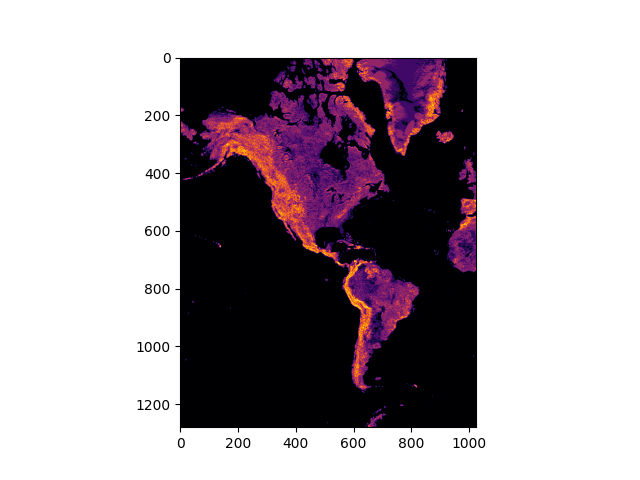

In [209]:
plt.imshow(world_map, cmap=plt.get_cmap("inferno"))
%matplot plt